# Exp15. 문자를 읽을 수 있는 딥러닝 (OCR)
- 사람이 문자를 읽으려면 문자가 있다는 것을 1) 인식하고, 인식한 문자를 2) 해독하는 과정을 거치는 것이 일반적이다. 
- 기계도 다르지 않은데, 문자의 존재를 1) Detection하고, 어떤 문자인지 판독하는 2) Recognition으로 나눌 수 있다. 

In [1]:
# Google Cloud Vision API 활용
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

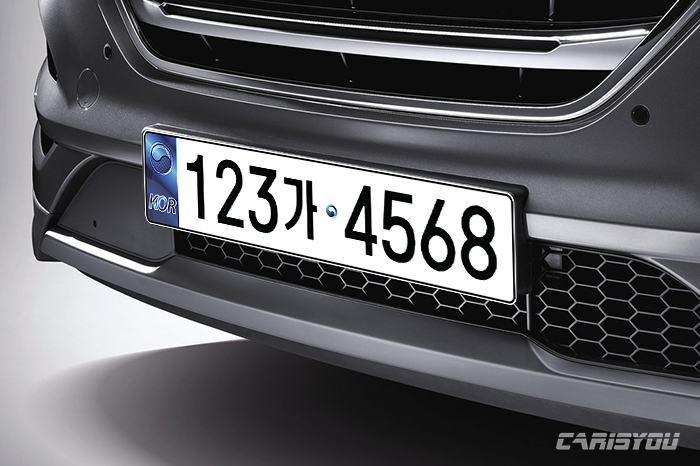  
이미지 출처 : [CARISYOU](https://www.google.com/url?sa=i&url=https%3A%2F%2Fm.carisyou.com%2Fmagazine%2FFOCUS%2F74536&psig=AOvVaw393bYgpXy-J5q8V_i1lg_r&ust=1645754813896000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCMiO5cugl_YCFQAAAAAdAAAAABAD)

In [2]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 한다. 
# 클라우드 환경에서는 무시해도 좋다. 
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로 지정
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.jpg'   

# 위에서 정의한 OCR API 이용 함수를 호출
detect_text(path)

Texts:

"1231-4568
KOR
CARISYOU
"

"1231-4568"

"KOR"

"CARISYOU"
bounds: (556,432),(679,433),(679,449),(556,448)


- 구글 API로 인식한 결과 번호판의 작은 KOR, 이미지 출처인 CARISYOU까지 잘 인식했지만 한글인 '가'는 인식하지 못했다. 아쉽군...
- 문자 모델은 보통 두 단계로 이루어진다. 먼저 입력받은 사진 속에서 문자의 위치를 찾아낸다. 이 과정을 Text Detection(문자검출)이라고 한다. 
- 찾은 문자 영역으로부터 문자를 읽어내는 것은 Text Recognition(문자인식)이다. 
- 아래 카카오의 OCR 모델은 먼저 문자가 있는 영역의 정보(`coord`, `Text Recognition`)을 찾아내고, 각 영역에서 문자를 인식하고 있다.  
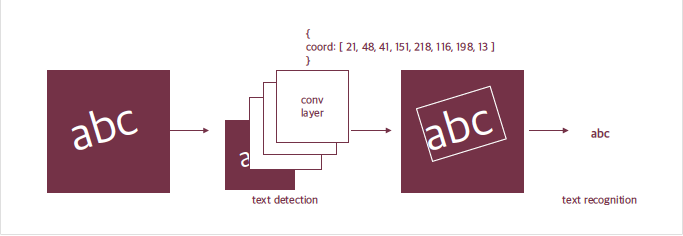  
이미지 출처 : https://brunch.co.kr/@kakao-it/318

- 위 그림에서는 문자의 영역을 표시하는 방법으로 사각형의 네 꼭짓점 좌표를 알려주는 방법을 제시하고 있다. 하지만 다른 도형이나 표현 방법을 쓸 수도 있을 것이다. 
- 이런 방법을 연구한 많은 논문 중 [Scene Text Detection with Polygon Offsetting and Border Augmentation](https://www.mdpi.com/2079-9292/9/1/117/pdf)에서는 축에 정렬된 사각형인 Bounding box, 그리고 돌아간 사각형 Oriented bounding box, 자유로은 사각형은 Quadrangle, 그리고 다각형인 Polygon, Pixel 수준으로 영역을 표현한 Mask등으로 문자의 영역을 표현한다. 

## 사진 속 문자 찾아내기 - Detection
- 사진 속 문자를 찾아내는 최근의 딥러닝 모델은 일반적인 Object Detection(객체 인식) 방법으로 접근한다. 
- 딥러닝 기반 객체 검출 방법에는 회귀 방식이나 세그멘테이션 방식이 있다. 회귀는 기준으로 하는 박스 대비 문자의 박스가 얼마나 차이가 나는지를 학습하고, 세그멘테이션은 픽셀 단위로 해당 픽셀이 문자를 표현하는지를 분류하는 문제라고 볼 수 있다.
- 일반적인 객체는 물체에 따라 크기가 일정한 특징을 갖는 반면 문자는 영역과 배치가 자유로워 문자를 검출하기 위한 설정이 필요하다. 
- 또한 객체는 물체 간 거리가 충분히 확보되는 반면 글자는 매우 촘촘하게 배치되어 있다. 
- 사진 속 문자를 검출할 때 문자, 단어, 단락 단위 등으로 검출해낼 수 있을 것이다. 

## 사진 속 문자 읽어내기 - Recognition
- 문자 인식은 사진 속에서 문자를 검출하는 모델이 영역을 잘라서 주면 그 영역에 어떤 글자가 포함되어 있는지 읽어내는 과정이다. 
- 사실 이 과정은 이미지 문제보다는 자연어 처리에서 많은 영감을 받았기에 이미지 내 문자 인식 모델의 기본적인 방법 중 하나는 CNN과 RNN을 결합한 CRNN 모델이다. 이미지 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후에 스텝 단위의 문자 정보를 RNN으로 인식하는 것이다. 

## Keras-OCR
- `keras-ocr`은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해준다. 
- 공식 문서에 따르면, 검출 모델로는 CRAFT(Character Region Awareness for Text Detection)를 상요하고, 인식 모델로는 CRNN을 사용한다. 
- `keras_ocr.pipeline.Pipeline()`는 인식을 위한 파이프라인을 생성하는데 이 때 초기화 과정에서 미리 학습된 모델의 weight를 불러온다. 

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras_ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 된다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [4]:
# 테스트에 사용할 이미지 url
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

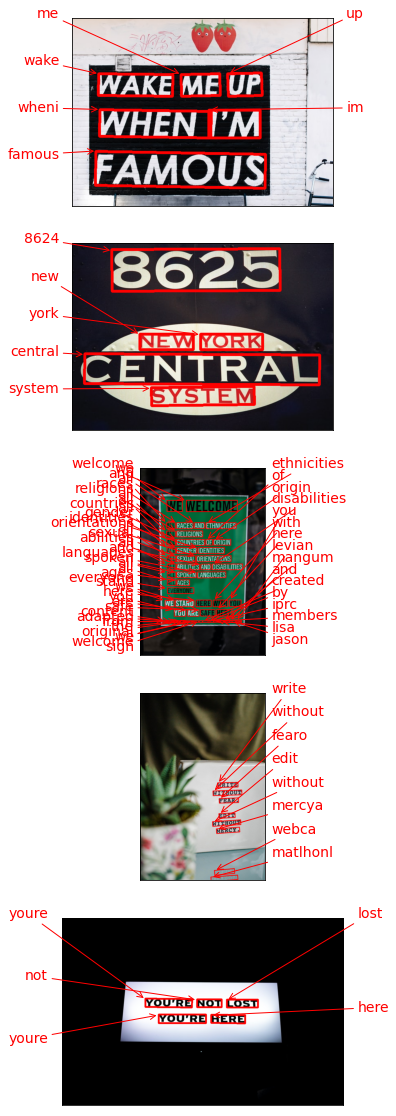

In [5]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## Tesseract OCR
- 테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tesseract.js 등으로 확장되는 등 많은 곳에서 사용되고 있다.
- 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116개 국어를 지원하고 있다. 

In [6]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfc

- `Pytesseract`는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리다. 

In [7]:
!sudo apt install tesseract-ocr-kor

import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-kor is already the newest version (1:4.00~git30-7274cfa-1).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-g

- `crop_word_regions()` 함수는 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴한다. 
- `pytesseract.image_to_data()`를 사용한다. 파이썬에서 편하게 사용하기 위해서 `pytesseract`의 `Output`을 사용해서 결과값의 형식을 딕셔너리 형태로 설정해 주게 된다. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 갖게 된다. 바운딩 박스를 이용해 이미지의 문자 영역들을 PIL 또는 opencv 라이브러리를 사용해 crop해서 `cropped_image_path_list`에 담아 리턴한다. 

In [8]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

뜨고

Done


- 번호판 이미지를 넣은 것 같은데 뜨고...가 나오다니... 다음 프로젝트에서 좀 더 다듬어 봐야겠다. 